In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader ,random_split , Dataset
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
import copy

C:\Users\yoavl\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_torch_dataset(size = False):
    if not size:
        size = 561
    all_data = []
    scaler = MinMaxScaler()
    columns = ['Input Voltage', 'Output Voltage', 'Tachometer']
    num_rows = 122824
    for i in range(1, size):
        temp_df = pd.read_csv(f'../PHM09_competition_1/Run_{i}.csv', names=columns, nrows=num_rows)
        normalized_data = scaler.fit_transform(temp_df)
        temp_tensor = torch.tensor(normalized_data, dtype=torch.float32)
        # temp_tensor = temp_tensor.unsqueeze(dim=0)  # Adding a channel dimension
        all_data.append(temp_tensor)
    
    all_data_tensor = torch.stack(all_data, dim=0)
    return all_data_tensor

dataset_tensor = create_torch_dataset()

In [3]:
dataset_tensor.shape

torch.Size([560, 122824, 3])

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        outputs, hidden = self.lstm(x)
        return hidden  # Return the hidden state for the decoder to use

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        output, hidden = self.lstm(x, hidden)
        output = self.linear(output)
        # output = self.relu(self.linear(output))
        return output

class GearboxFaultDetectionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GearboxFaultDetectionLSTM, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, num_layers)
        self.decoder = Decoder(input_size, hidden_size, num_layers, input_size)

    def forward(self, x):
        hidden = self.encoder(x)
        # Decoder takes the input sequence again and the hidden state from the encoder
        output = self.decoder(x, hidden)
        return output

In [5]:
def preprocess_data(data, subsequence_length):
    # data is of shape [batch_size, sequence_length, feature_size]
    batch_size, sequence_length, feature_size = data.shape

    # Determine the number of subsequences we can get from each sequence
    num_subsequences_per_sequence = sequence_length // subsequence_length

    # Calculate new shape
    new_batch_size = batch_size * num_subsequences_per_sequence
    new_sequence_length = subsequence_length

    # Reshape data
    reshaped_data = data.unfold(1, new_sequence_length, new_sequence_length)
    reshaped_data = reshaped_data.contiguous().view(new_batch_size, new_sequence_length, feature_size)
    print(reshaped_data.shape)
    return reshaped_data

def train_model(model, train_dataset, val_dataset, n_epochs):
    best_loss = float('inf')
    # best_model_wts = copy.deepcopy(model.state_dict())
    history = {'train': [], 'val': []}
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.L1Loss(reduction='sum')
    train_loss = 0

    for epoch in range(1, n_epochs + 1):
        model = model.train()
        train_loss = []
        for seq_true in train_dataset:
            optimizer.zero_grad()
            seq_pred = model(seq_true)
            loss = loss_fn(seq_pred, seq_true)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Eval loop 
        val_loss = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_pred = model(seq_true)
                loss = loss_fn(seq_pred,seq_true)
                val_loss.append(loss.item())
            
        avg_train_loss = sum(train_loss) / len(train_loss)
        avg_val_loss = sum(val_loss) / len(val_loss)
        history['train'].append(avg_train_loss)
        history['val'].append(avg_val_loss)

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            # best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {avg_train_loss} val loss {avg_val_loss}')
        # model.load_state_dict(best_model_wts)
    
    return model, history
    
subsequence_length = 1024
preprocessed_dataset_tensor = preprocess_data(dataset_tensor, subsequence_length)

input_size = 3  # As there are 3 features in each timestep
hidden_size = 25  # Example hidden size, tune this based on the complexity of the data
num_layers = 2   # Number of LSTM layers

model = GearboxFaultDetectionLSTM(3,25,2)

# Prepare DataLoaders
train_size = int(0.8 * len(preprocessed_dataset_tensor))
val_size = len(preprocessed_dataset_tensor) - train_size
train_dataset, val_dataset = random_split(preprocessed_dataset_tensor, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)


model, history = train_model(model, train_dataloader, val_dataloader, n_epochs=3)

torch.save(model, f'model2_{n_epochs}.pth')
print("Entire model saved successfully.")

torch.Size([66640, 1024, 3])
Epoch 1: train loss 2792.7891771332556 val loss 768.3131756313699
Epoch 2: train loss 665.4418262605335 val loss 553.7989932272932
Epoch 3: train loss 547.4296602979571 val loss 473.19819827731567


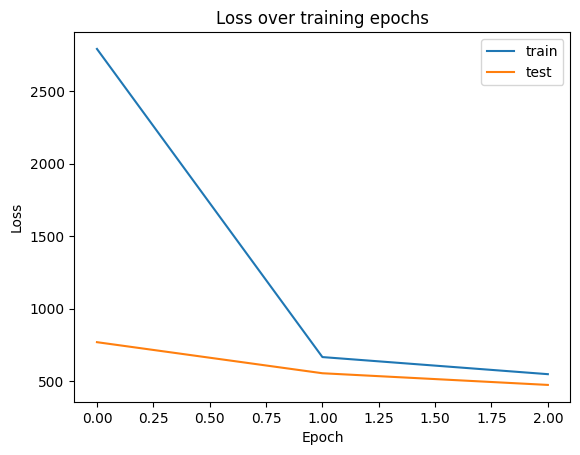

<Figure size 640x480 with 0 Axes>

In [16]:
# This plot should help to choose the THRESHOLD
ax = plt.figure().gca()
ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();
plt.savefig('../img/loss_plot.png')

In [7]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum')
  # criterion = nn.MSELoss()
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
      result_df = pd.DataFrame({
        'Run_id': range(1, len(predictions) + 1),
        'Loss':losses,
    })
  return result_df , predictions, losses

df_pred ,predictions, losses = predict(model , dataset_tensor)

C:\Users\yoavl\AppData\Local\Temp\ipykernel_22308\1360621379.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


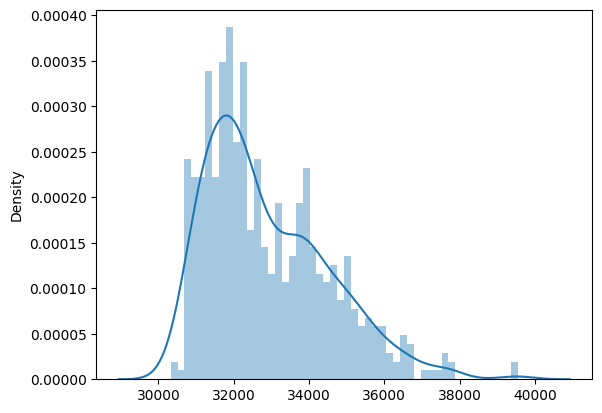

In [8]:
sns.distplot(losses, bins=50, kde=True);

In [9]:
THRESHOLD = 37000
correct = sum(l <= THRESHOLD for l in losses)
correct

550

In [11]:
anomaly = df_pred[df_pred['Loss'] >= THRESHOLD].index
anomaly_list = list(anomaly)
anomaly_list

[101, 139, 149, 179, 192, 280, 282, 396, 403, 546]

In [12]:
def append_anomalies_to_csv(anomaly_list, file_name):
    """
    Appends the given anomaly list to an existing CSV file, or creates a new one if it doesn't exist.
    Also adds a column indicating the length of the anomaly list.
    
    :param anomaly_list: List of anomaly indices.
    :param file_name: Name of the CSV file to append to or create.
    """
    try:
        existing_df = pd.read_csv(file_name)
    except FileNotFoundError:
        existing_df = pd.DataFrame(columns=['Index', 'Anomaly', 'Length'])
    
    # Create a new DataFrame from the anomaly list
    new_data = pd.DataFrame({'Anomaly': [anomaly_list], 'Length': [len(anomaly_list)]})
    new_data['Index'] = existing_df.shape[0] + 1

    # Append the new data to the existing DataFrame
    updated_df = pd.concat([existing_df, new_data], ignore_index=True)

    # Save the updated DataFrame to the CSV file
    updated_df.to_csv(file_name, index=False)

append_anomalies_to_csv(anomaly_list,'anomaly.csv')

df = pd.read_csv('anomaly.csv')
df

,Index,Anomaly,Length
0,1,"[0, 6, 7, 8, 18, 26, 35, 36, 55, 57, 62, 65, 6...",76
1,2,"[21, 26, 53, 68, 79, 80, 82, 88, 94, 115, 125,...",63
2,3,"[0, 1, 36, 53, 57, 67, 68, 82, 84, 88, 101, 10...",54
3,4,"[53, 68, 82, 88, 160, 162, 196, 207, 222, 282,...",17
4,5,"[207, 431]",2
5,6,"[53, 68, 82, 160, 162, 207, 282, 310, 354, 396...",13
6,7,"[101, 139, 149, 179, 192, 280, 282, 396, 403, ...",10


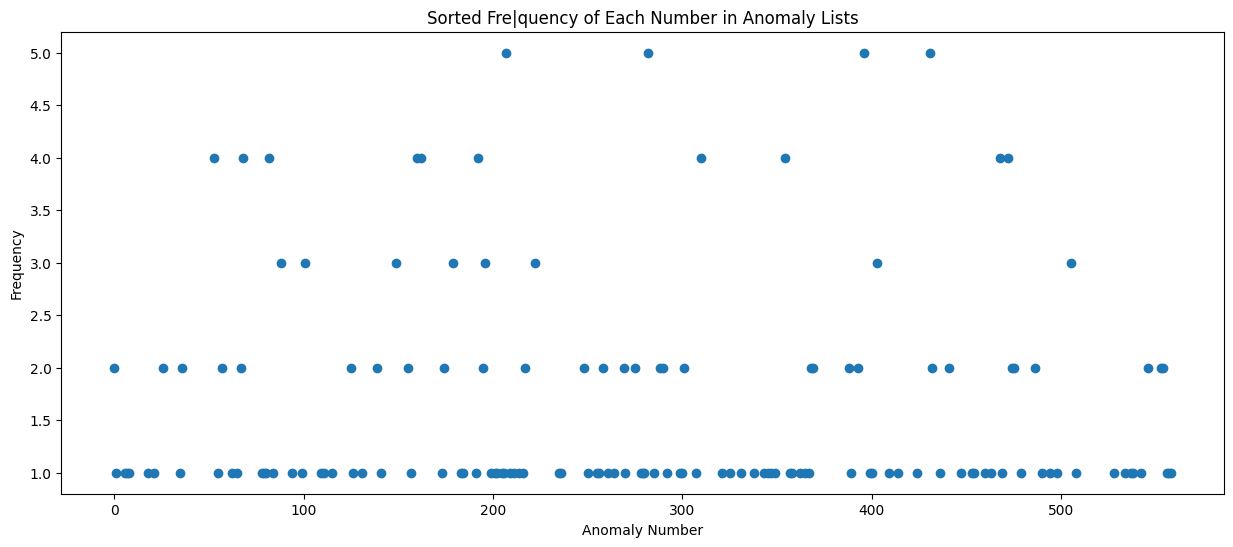

In [13]:
from collections import Counter
from ast import literal_eval
def plot_anomaly_frequency_sorted(df):
    # Extracting all numbers from the 'Anomaly' lists and flattening them into a single list
    all_anomalies = [num for sublist in df['Anomaly'].apply(literal_eval) for num in sublist]
    anomaly_counts = Counter(all_anomalies)
    # Sorting the counts
    sorted_anomaly_counts = dict(sorted(anomaly_counts.items()))
    plt.figure(figsize=(15, 6))
    plt.scatter(sorted_anomaly_counts.keys(), sorted_anomaly_counts.values())
    plt.xlabel('Anomaly Number')
    plt.ylabel('Frequency')
    plt.title('Sorted Fre|quency of Each Number in Anomaly Lists')
    plt.show()

plot_anomaly_frequency_sorted(df)